# Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from glob import glob
from IPython.display import FileLink
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from os import makedirs
from os.path import join, exists, expanduser
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Create the directories for the pretrained models

cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)
    
!ls ~/.keras/models  
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

Using TensorFlow backend.


# Getting Dataset

In [2]:
filepath = '../input/data/' #The file path for the input data
xray_df = pd.read_csv(os.path.join(filepath,'Data_Entry_2017.csv')) #Reading csv and convert it to dataframe
image_path = glob(os.path.join(filepath,'images_???','images','*.png')) #Getting all image paths 
image_paths = { os.path.basename(x): x for x in image_path } 
xray_df['path'] = xray_df['Image Index'].map(image_paths.get) #Mapping image with there image index
xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030801_001.png
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030802_000.png
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030803_000.png
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030804_000.png


# Analysis

## Total Label Counts

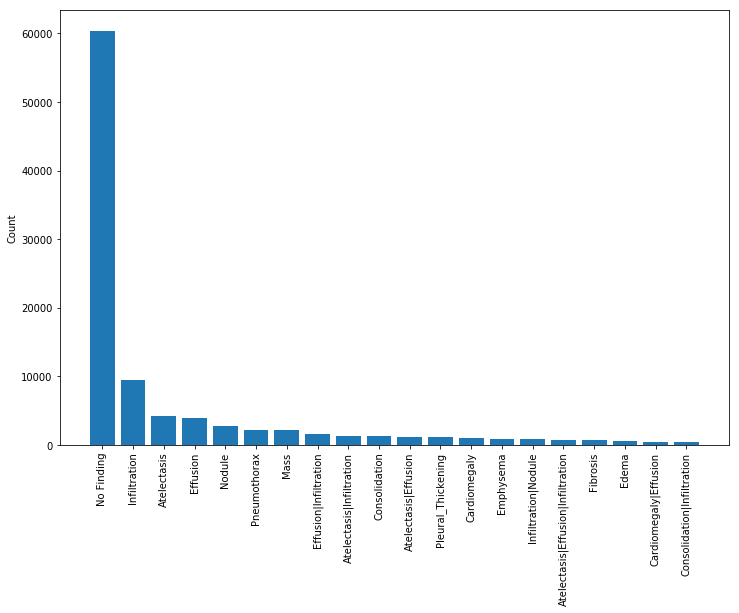

In [3]:
total_labels = xray_df['Finding Labels'].value_counts()[0:20] #Finding the total labels 
fig, ax1 = plt.subplots(1,1,figsize = (12, 8)) #Plotting the labels
ax1.bar(np.arange(len(total_labels))+0.5, total_labels)
ax1.set_xticks(np.arange(len(total_labels))+0.5)
_ = ax1.set_xticklabels(total_labels.index, rotation = 90)
_ = ax1.set_ylabel('Count')
fig.savefig('findings_distribution.png')

## Distribution of Age of Patients

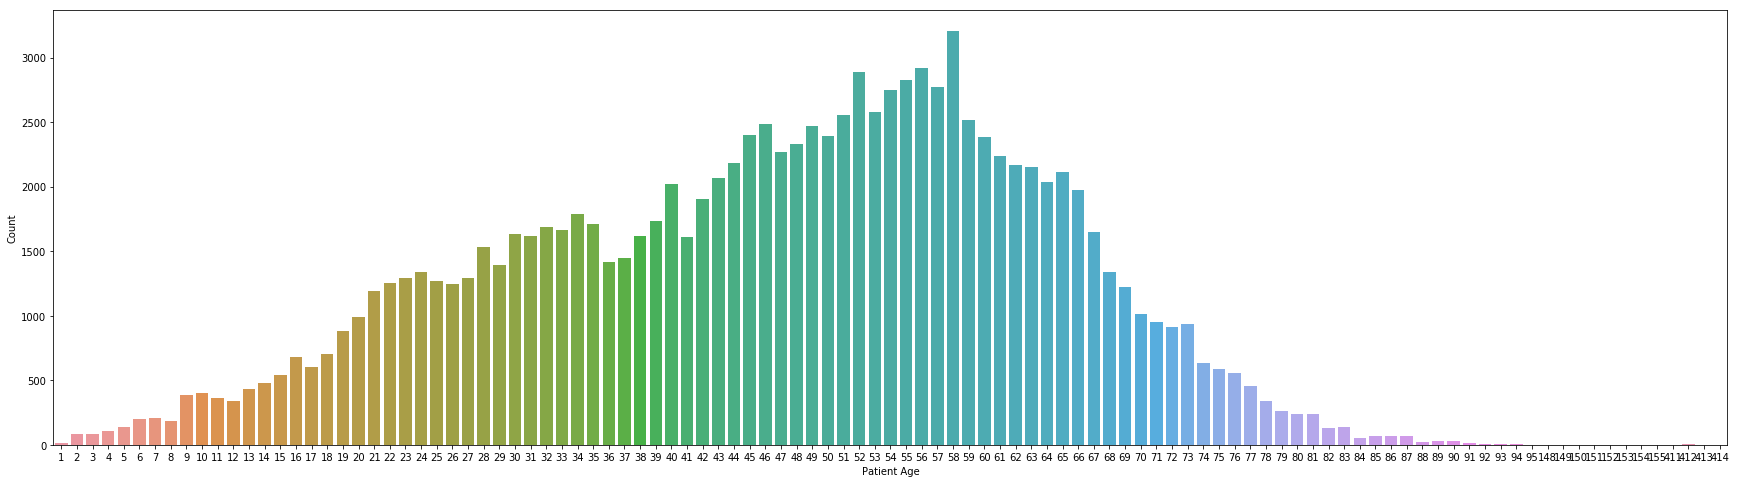

In [4]:
ax = plt.figure(figsize=(30, 8)) #Plotting the age distribution plot
sns.countplot(xray_df['Patient Age'])
plt.xlabel('Patient Age')
plt.ylabel('Count')
plt.savefig('age_distribution.png')

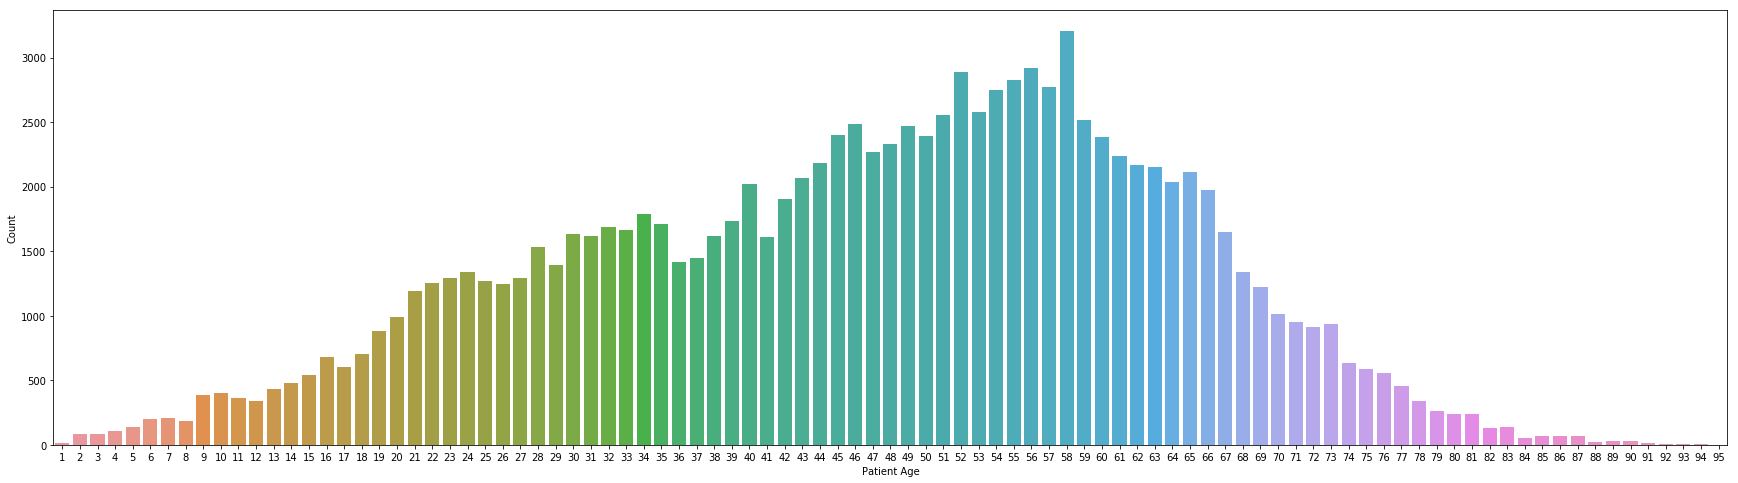

In [5]:
indeces=[]
for index in range(len(xray_df)):
    if xray_df['Patient Age'][index]>100: #Removing the age which can't be possible 
        indeces.append(index)
xray_df = xray_df.drop(indeces,axis=0)
ax = plt.figure(figsize=(30, 8))
sns.countplot(xray_df['Patient Age'])
plt.xlabel('Patient Age')
plt.ylabel('Count')
plt.savefig('age_distribution_new.png')

# Pre-processing

In [6]:
from itertools import chain
total_labels = np.unique(list(chain(*xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist()))) #Splitting the finding labels and get the labels
xray_df['Finding Labels List'] = xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist() 
for c_label in total_labels:
    xray_df[c_label] = xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)

## Patients Diseases Frequency

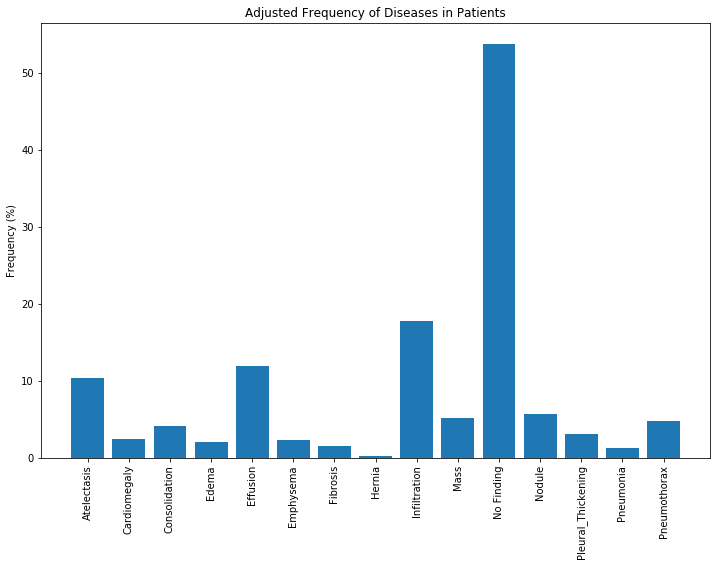

In [7]:
total_counts = 100*np.mean(xray_df[total_labels].values,0) #Plotting the adjusted frequency of diseases in patients
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(total_counts))+0.5, total_counts)
ax1.set_xticks(np.arange(len(total_counts))+0.5)
ax1.set_xticklabels(total_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patients')
_ = ax1.set_ylabel('Frequency (%)')
fig.savefig('frequency_distribution.png')

In [8]:
xray_df.drop(['Image Index','Finding Labels','Follow-up #','OriginalImage[Width','Height]', 'OriginalImagePixelSpacing[x','y]','Unnamed: 11'],axis=1, inplace=True) #Dropping the columns which are not necessary
xray_df['Patient Gender'] = xray_df['Patient Gender'].map(lambda gender: 0 if gender=='M' else 1)
xray_df['View Position'] = xray_df['View Position'].map(lambda vp: 0 if vp=='AP' else 1)

In [9]:
patients=np.unique(xray_df['Patient ID'])

train_valid, test = train_test_split(patients, test_size = 0.2, random_state = 2020) #Splitting train+valid and test in ration of 8:2  
train, valid = train_test_split(train_valid, test_size = 0.12, random_state = 2020) #Splitting train and valid  
print('Unique in Train dataset : ',len(train))
print('Unique in Valid dataset : ',len(valid))
print('Unique in Test dataset  : ',len(test))

train_df = xray_df[xray_df['Patient ID'].isin(train)]
valid_df = xray_df[xray_df['Patient ID'].isin(valid)]
test_df = xray_df[xray_df['Patient ID'].isin(test)]
print('\nTotal Training dataset   : ', train_df.shape[0],' images')
print('Total Validation dataset : ', valid_df.shape[0],' images')
print('Total Testing dataset    : ', test_df.shape[0],' images')

Unique in Train dataset :  21684
Unique in Valid dataset :  2957
Unique in Test dataset  :  6161

Total Training dataset   :  78481  images
Total Validation dataset :  10836  images
Total Testing dataset    :  22787  images


## Normalize Patient's Data

In [10]:
#Normalizing patients age data in train, valid and test

pd.options.mode.chained_assignment = None
min_age = min(train_df['Patient Age'])
diff = max(train_df['Patient Age']) - min_age
train_df['Patient Age'] = train_df['Patient Age'].map(lambda age: (age-min_age)/diff)
train_df.drop('Patient ID',axis=1,inplace=True)

min_age = min(valid_df['Patient Age'])
diff = max(valid_df['Patient Age']) - min_age
valid_df['Patient Age'] = valid_df['Patient Age'].map(lambda age: (age-min_age)/diff)
valid_df.drop('Patient ID',axis=1,inplace=True)

min_age = min(test_df['Patient Age'])
diff = max(test_df['Patient Age']) - min_age
test_df['Patient Age'] = test_df['Patient Age'].map(lambda age: (age-min_age)/diff)
test_df.drop('Patient ID',axis=1,inplace=True)

# Making a Predicting Model 

In [11]:
IMG_SIZE = (224, 224) #We had taken image size of (224,224)
data_gen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15) #We are creating image data

In [12]:
train_gen = data_gen.flow_from_dataframe(dataframe=train_df, directory=None, x_col = 'path', y_col = 'Finding Labels List', target_size = IMG_SIZE, class_mode='categorical', color_mode = 'grayscale', batch_size = 64)
valid_gen = data_gen.flow_from_dataframe(dataframe=valid_df, directory=None, x_col = 'path', y_col = 'Finding Labels List', target_size = IMG_SIZE, color_mode = 'grayscale', class_mode='categorical', batch_size = 64)
test_gen = data_gen.flow_from_dataframe(dataframe=test_df, directory=None, x_col = 'path', y_col ='Finding Labels List', target_size = IMG_SIZE, color_mode = 'grayscale', class_mode='categorical', batch_size = 64) 

Found 78481 validated image filenames belonging to 15 classes.
Found 10836 validated image filenames belonging to 15 classes.
Found 22787 validated image filenames belonging to 15 classes.


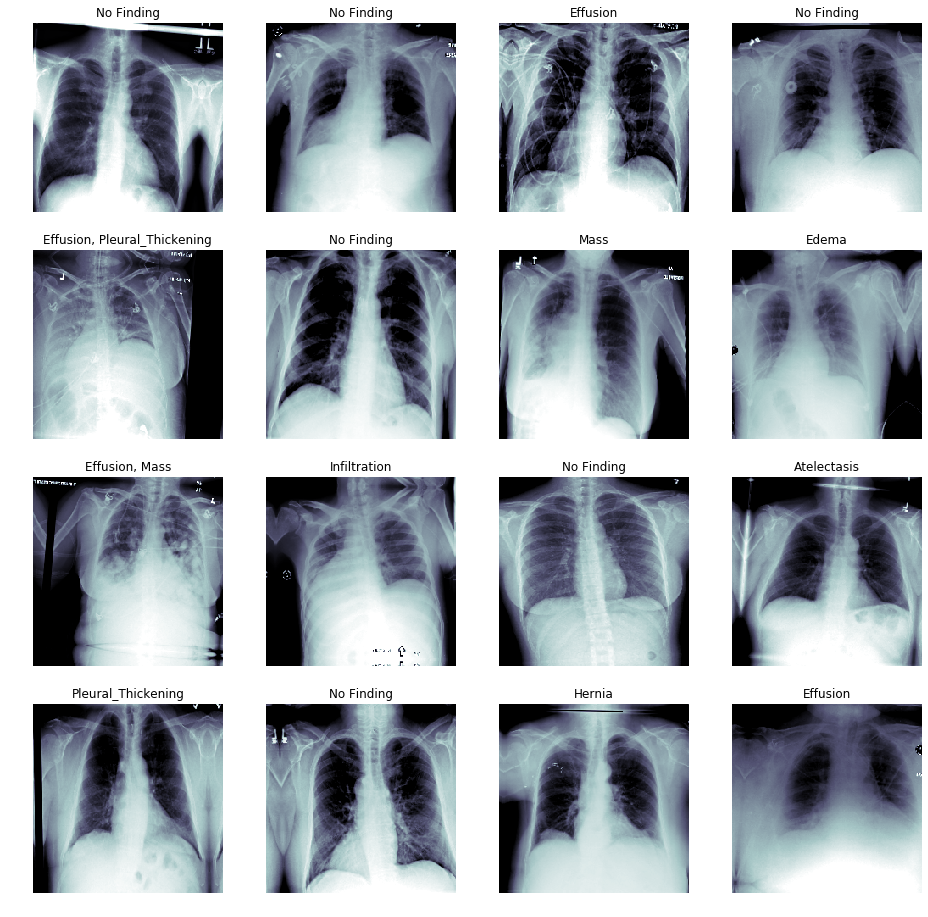

In [13]:
#printing the image with its findings
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(train_gen.class_indices.keys(), c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

fig.savefig('train_gen_samples.png')
train_gen.reset()

In [14]:
weight_path="{}_weights.best.hdf5".format('xray_class')

#Making a call back list which is consist of check point, early stop, lr_reduce
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=7, verbose=1, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=2, mode='min')
callbacks_list = [checkpoint, early_stop, lr_reduce]
base_ResNet50 = ResNet50(include_top = False, weights = 'imagenet') #Using the pretrained resnet50 model which is trained on imagenet

model = Sequential() #making a model

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [15]:
convol_same = Conv2D(trainable=False, input_shape= t_x.shape[1:], filters=3, kernel_size=(1, 1), strides=(1, 1), 
                     padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, 
                     kernel_initializer='ones', bias_initializer='zeros', kernel_regularizer=None, 
                     bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

In [16]:
model.add(convol_same) #adding Conv_2D layer to model
model.add(base_ResNet50) #adding Resnet50 layer to model
model.add(GlobalAveragePooling2D()) #adding Global Average Pooling layer to model
model.add(Dense(len(total_labels), activation = 'sigmoid')) #Adding the dense layer
# model.load_weights('../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 3)       6         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                30735     
Total params: 23,618,453
Trainable params: 23,565,327
Non-trainable params: 53,126
_________________________________________________________________


In [17]:
from keras import optimizers
adam = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False) 
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy']) #compling the model with adam optimizer

**Arguments**
* learning_rate: float >= 0. Learning rate.
* beta_1: float, 0 < beta < 1. Generally close to 1.
* beta_2: float, 0 < beta < 1. Generally close to 1.
* amsgrad: boolean. Whether to apply the AMSGrad variant of this algorithm from the paper "On the Convergence of Adam and Beyond".

In [18]:
with open('model_resnet.json', 'w') as f: 
    f.write(model.to_json())

In [19]:
total = xray_df.shape[0]
class_weights = {}
for key in train_gen.class_indices.keys():
    amount = xray_df['Finding Labels List'].map(lambda x: key in x).sum()
    class_number = train_gen.class_indices[key]
    class_weights [class_number] = total/amount

## Fitting the Model 

In [20]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=train_gen.n//train_gen.batch_size,
                              validation_data = valid_gen, 
                              validation_steps = valid_gen.n//valid_gen.batch_size,
                              epochs = 10, 
                              class_weight = class_weights,
                              callbacks = callbacks_list) #Fitting the Model 

model.save_weights('weights_model_resnet.h5') #Saving the Weights

Epoch 1/10
1226/1226 [==============================] - 2222s 2s/step - loss: 2.7763 - accuracy: 0.9113 - val_loss: 0.2339 - val_accuracy: 0.9141

Epoch 00001: val_loss improved from inf to 0.23390, saving model to xray_class_weights.best.hdf5
Epoch 2/10
1226/1226 [==============================] - 2201s 2s/step - loss: 2.5278 - accuracy: 0.9138 - val_loss: 0.2385 - val_accuracy: 0.9139

Epoch 00002: val_loss did not improve from 0.23390
Epoch 3/10
1226/1226 [==============================] - 2293s 2s/step - loss: 2.4367 - accuracy: 0.9146 - val_loss: 0.2335 - val_accuracy: 0.9149

Epoch 00003: val_loss improved from 0.23390 to 0.23345, saving model to xray_class_weights.best.hdf5
Epoch 4/10
1226/1226 [==============================] - 2292s 2s/step - loss: 2.3653 - accuracy: 0.9147 - val_loss: 0.2352 - val_accuracy: 0.9112

Epoch 00004: val_loss did not improve from 0.23345
Epoch 5/10
1226/1226 [==============================] - 2310s 2s/step - loss: 2.3289 - accuracy: 0.9149 - val_lo

/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 347 could not be retrieved. It could be because a worker has died.
  UserWarning)


1226/1226 [==============================] - 2320s 2s/step - loss: 1.9964 - accuracy: 0.9177 - val_loss: 0.2259 - val_accuracy: 0.9131

Epoch 00009: val_loss did not improve from 0.22083
Epoch 10/10
1226/1226 [==============================] - 2314s 2s/step - loss: 1.9539 - accuracy: 0.9180 - val_loss: 0.2387 - val_accuracy: 0.9157

Epoch 00010: val_loss did not improve from 0.22083

Epoch 00010: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.


In [21]:
with open('model_resnet.json', 'r') as f:
    model = model_from_json(f.read())
model.load_weights('weights_model_resnet.h5') #Loading the saved weights

## Predict the test dataset

In [22]:
test_gen.reset()
steps = len(test_gen.classes)//test_gen.batch_size

test_y_list = []
pred_y_list = []

for i in tqdm(range(steps)):
    test_X, test_Y = next(test_gen)
    pred_Y = model.predict(test_X)
    test_y_list.append(test_Y)
    pred_y_list.append(pred_Y)
    
test_y_all = np.concatenate(test_y_list)
pred_y_all = np.concatenate(pred_y_list)

100%|██████████| 356/356 [10:12<00:00,  1.72s/it]


In [23]:
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
test_gen.reset()
steps = len(test_gen.classes)//test_gen.batch_size

test_acc_list = []
test_loss_list = []

for i in range(steps):
    test_X, test_Y = next(test_gen)
    test_loss,test_acc = model.evaluate(test_X,test_Y,test_gen.batch_size,verbose=0)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
test_accuracy = np.mean(test_acc_list)
test_loss = np.mean(test_loss_list)
print('Test Accuracy : ',test_accuracy,'Test Loss : ',test_loss)

Test Accuracy :  0.9148525200533063 Test Loss :  0.22321931854560134


In [24]:
pred_y_pickle = open("prediction.pkl", 'wb')
pickle.dump(pred_y_all, pred_y_pickle)
pred_y_pickle.close()
test_y_pickle = open("test_true.pkl", 'wb')
pickle.dump(test_y_all, test_y_pickle)

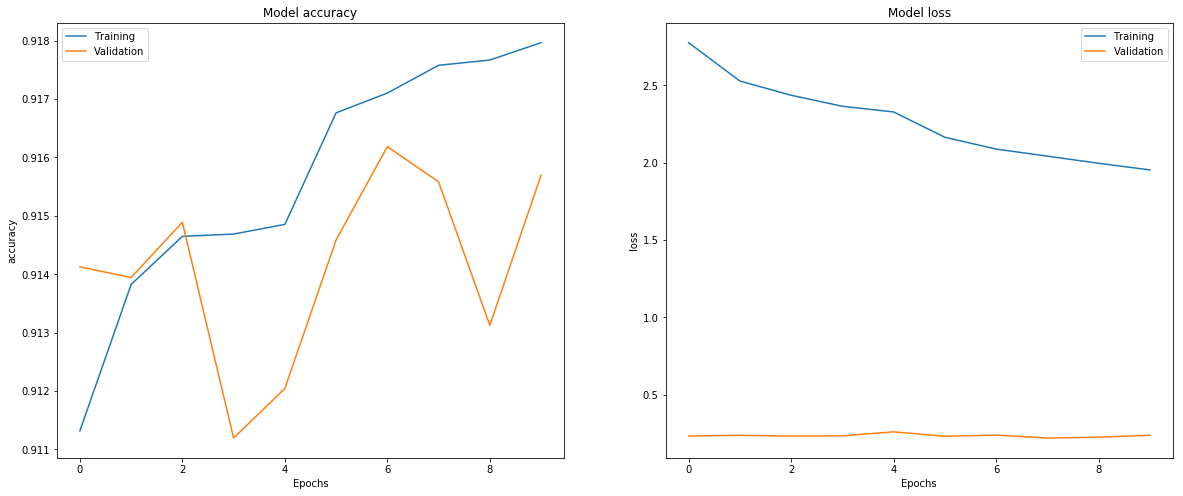

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['Training', 'Validation'])
fig.savefig('accuracy_and_loss_plot.png') #Plotting Validation vs Training Accuracy 

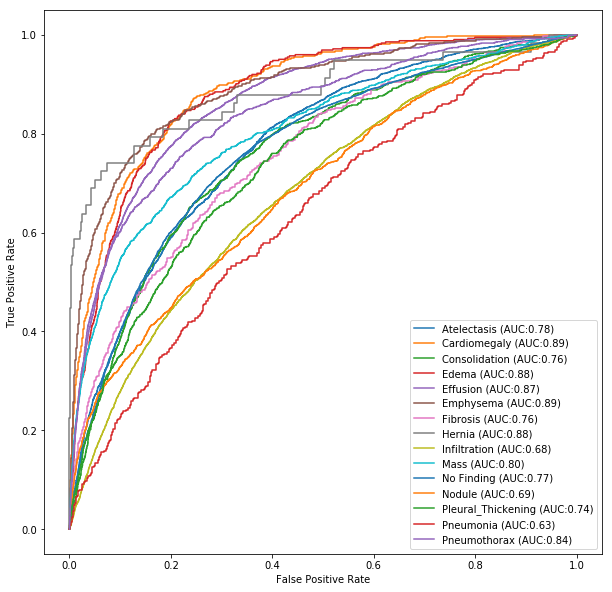

In [26]:
fig, c_ax = plt.subplots(1,1, figsize = (10, 10)) #making the AUC for comparing different labels
for (idx, c_label) in enumerate(test_gen.class_indices.keys()):
    fpr, tpr, thresholds = roc_curve(test_y_all[:,idx].astype(int), pred_y_all[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('roc_auc_curve.png')

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


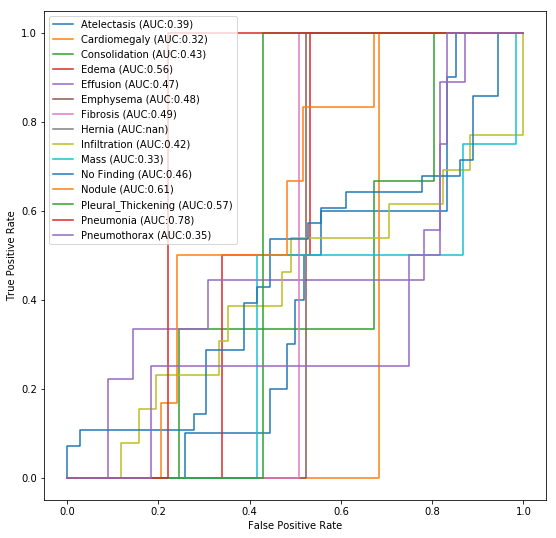

In [27]:
from sklearn.metrics import roc_curve, auc  
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(total_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [28]:
for c_label, p_count in zip(total_labels, 
                                     100*np.mean(pred_Y,0)):
    print('%s: %2.2f%%' % (c_label, p_count))

Atelectasis: 15.15%
Cardiomegaly: 7.35%
Consolidation: 8.60%
Edema: 7.82%
Effusion: 17.24%
Emphysema: 5.75%
Fibrosis: 4.58%
Hernia: 0.16%
Infiltration: 24.95%
Mass: 9.38%
No Finding: 15.09%
Nodule: 7.67%
Pleural_Thickening: 7.85%
Pneumonia: 5.32%
Pneumothorax: 9.81%


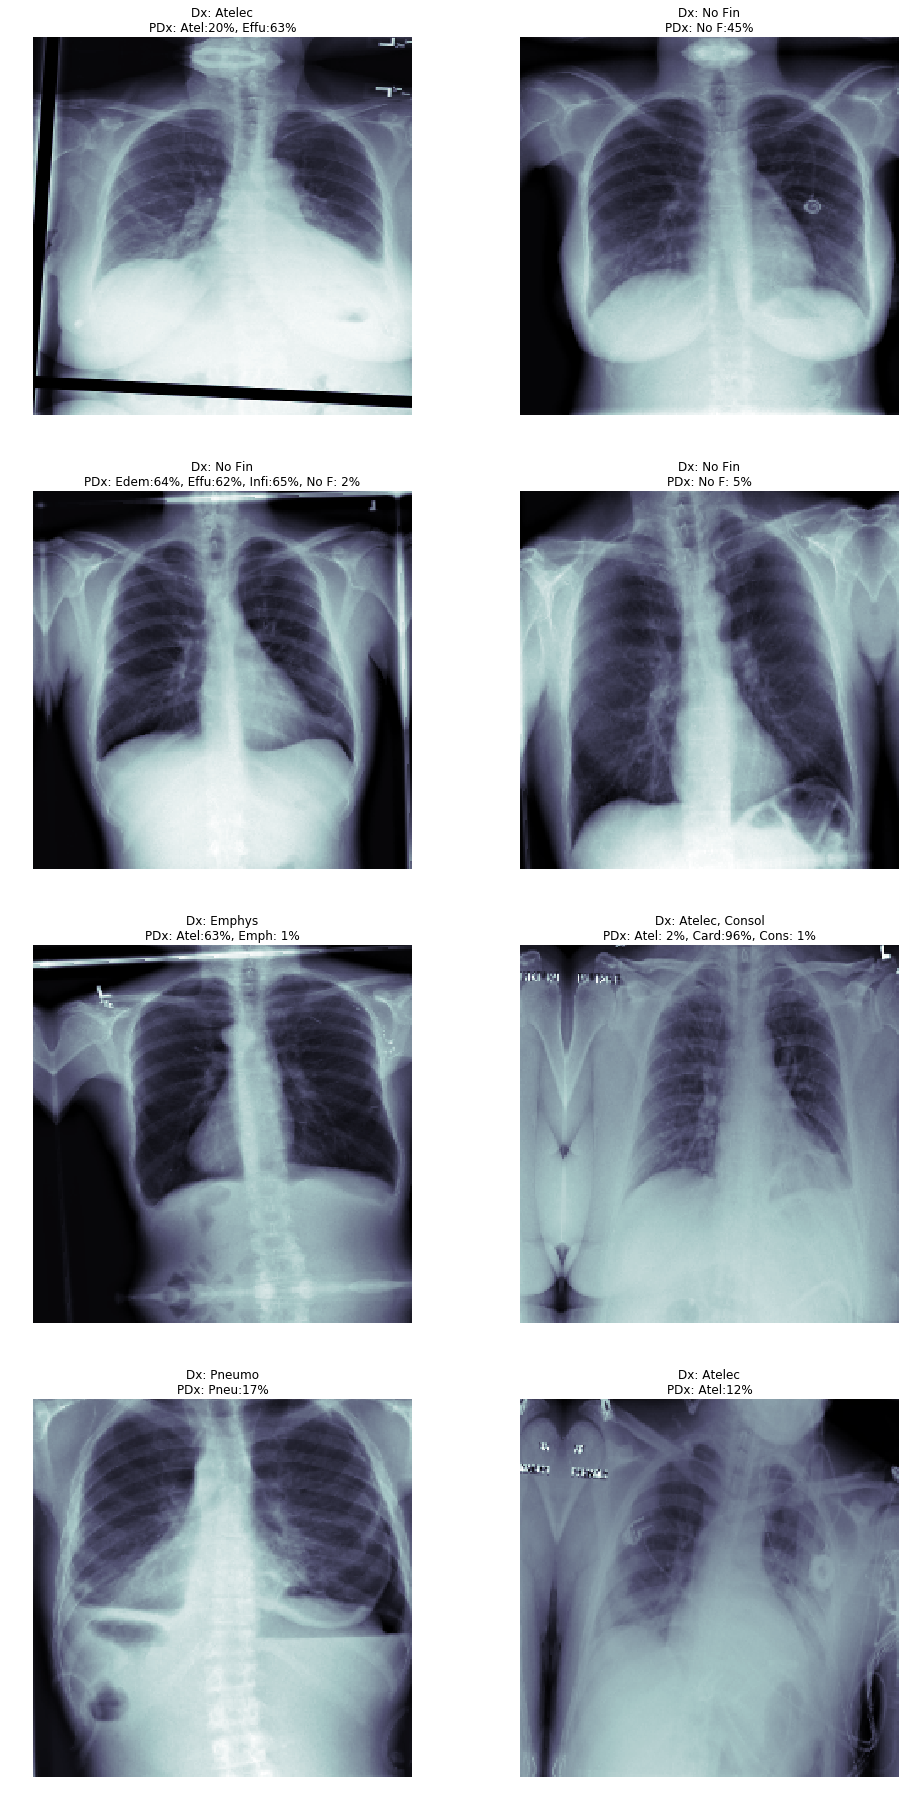

In [29]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(total_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(total_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')

In [30]:
os.chdir(r'/kaggle/working')
FileLink(r'roc_auc_curve.png')
FileLink(r'accuracy_and_loss_plot.png')

/kaggle/working/accuracy_and_loss_plot.png